# Dataset Merge, Preprocessing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.neighbors import KernelDensity
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from google.colab import drive
import pickle
import os

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Tau_DIR = '/content/gdrive/MyDrive/Neuro_Tau/UCBERKELEY_TAUPVC_6MM_14Feb2024.csv'
AMY_DIR = '/content/gdrive/MyDrive/Neuro_Tau/UCBERKELEY_AMY_6MM_17Feb2024.csv'
ADNI_Merge_DIR = '/content/gdrive/MyDrive/Neuro_Tau/ADNIMERGE_17Feb2024.csv'

Tau= pd.read_csv(Tau_DIR)
AMY= pd.read_csv(AMY_DIR)
ADNI_Merge= pd.read_csv(ADNI_Merge_DIR)


<ipython-input-38-a24c889f4393>:7: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  ADNI_Merge= pd.read_csv(ADNI_Merge_DIR)


"\noutput = pd.DataFrame({'Id': test_df['Id'], 'target': predictions})\n\npath_in_google_drive = '/content/gdrive/MyDrive/AP 3/submission.csv'\n\n\noutput.to_csv(path_in_google_drive, index=False)\n"

In [ ]:
unique_rid_count = Tau['RID'].nunique()
print(unique_rid_count)

print (Tau.shape)


AMY_1 = AMY
unique_rid_count_AMY_1 = AMY_1['RID'].nunique()
print(unique_rid_count_AMY_1)

print (AMY_1.shape)


DEMO_1 = ADNI_Merge
unique_rid_count_DEMO_1 = DEMO_1['RID'].nunique()
print(unique_rid_count_DEMO_1)

print (DEMO_1.shape)

# ******\\\\\\IDENTIFY LONGITUDINAL DATA BASED ON RID DUPLICATES = TWO TIME POINTS FOR SAME PT *******//////////#

# Identify all duplicate values in column RID (indicate longitudinal data)
# `keep=False` marks all duplicates as True
duplicates = Tau.duplicated('RID', keep=False)

# Filter the DataFrame to include only duplicates of RID
filtered_Tau = Tau[duplicates]
unique_rid_count = filtered_Tau['RID'].nunique()
print(f"Number of unique RID longitudinal data: {unique_rid_count}")
print(filtered_Tau.shape)



# ******\\\\\\FILTER OUT UNEEDED COLUMNS, KEEP ROI *******//////////#

# Keep RID , SCANDATE columns
specific_indexes_to_keep = [1, 5]
columns = filtered_Tau.columns.tolist()

# Keep columns by specified indexes
specific_columns_to_keep = [columns[i] for i in specific_indexes_to_keep]

# Filter columns after index 5 to keep only those containing 'ctx'
columns_after_index_0_with_ctx = [col for col in columns if 'CTX' in col]

words = ['AMYGDALA', 'ACCUMBENS', 'CAUDATE', 'HIPPOCAMPUS', 'PALLIDUM', 'PUTAMEN', 'THALAMUS']
Specific_columns = [col for col in columns if any(word in col for word in words)]
columns_to_keep = specific_columns_to_keep + columns_after_index_0_with_ctx+ Specific_columns

# Select only the columns to keep in the DataFrame
Remaining_columns = filtered_Tau[columns_to_keep]

#Filter out all volume columns but leave SUVR and first few Identifier rows
columns_to_drop1 = [col for col in Remaining_columns.columns if "VOLUME" in col.upper()]
Remaining_columns = Remaining_columns.drop(columns=columns_to_drop1)

#print head of remaining_col
Remaining_columns.head()

print(Remaining_columns.shape)



# ******\\\\\\EXTRACT PT DEMOGRAPHIC FROM ADNIMERGE *******//////////#

#ADNI MERGE
#read ADNIMERGE columns 'PTGENDER' and 'APOE4' and insert them into tau data for matching 'RID's
# (Use low_memory=False to avoid error due to mixed type of data)
Tau_Data=Remaining_columns
ADNI_Merge = ADNI_Merge

# Drop duplicates in csv1 to ensure each 'RID' only has one set of values for 'PTGENDER' and 'APOE4'
ADNI_Merge = ADNI_Merge.drop_duplicates(subset='RID')

# Map 'PTGENDER' and 'APOE4'based on 'RID'
Tau_Demographics = Tau_Data.merge(ADNI_Merge[['RID', 'PTGENDER','DX_bl', 'APOE4']], on='RID', how='left')

# ******\\\\\\EXTRACT PT AGE BASED ON THE REPORTED AGE IN ADNIMERGE + TIME DIFFERENCE OF SCANDATE AND EXAMDATE(age reported date) *******//////////#
#For each RID in Tau_Demographics  matching RID in ADNI_Merge ,
#find the row that has the year of EXAMDATE of adnimerge to be matching SCANDATE Tau_Demographics
#create latest_ages is a dictionary mapping each RID to the latest AGE from the ADNI_Merge dataset. This age is then added to the Tau_Demographics DataFrame.
#Then, year_difference is calculated as the difference between the SCANDATE_YEAR in Tau_Demographics and the latest EXAMDATE_YEAR in ADNI_Merge.
#This difference is used to adjust the age accordingly. If there's no matching RID from ADNI_Merge in Tau_Demographics, the age is set to 0.

# Convert to datetime
Tau_Demographics['SCANDATE'] = pd.to_datetime(Tau_Demographics['SCANDATE'])
ADNI_Merge['EXAMDATE'] = pd.to_datetime(ADNI_Merge['EXAMDATE'])

# Extract years
Tau_Demographics['SCANDATE_YEAR'] = Tau_Demographics['SCANDATE'].dt.year
ADNI_Merge['EXAMDATE_YEAR'] = ADNI_Merge['EXAMDATE'].dt.year

# Get the latest age and examdate year for each RID in ADNI_Merge
latest_exam_info = ADNI_Merge.sort_values('EXAMDATE').groupby('RID').agg({'AGE': 'last', 'EXAMDATE_YEAR': 'last'}).reset_index()

# Merge the latest exam information with Tau_Demographics based on RID
Tau_Demographics = Tau_Demographics.merge(latest_exam_info, on='RID', how='left', suffixes=('', '_ADNI'))

# Calculate the age at SCANDATE for each RID in Tau_Demographics
Tau_Demographics['AGE_AT_SCANDATE'] = Tau_Demographics['AGE'] + (Tau_Demographics['SCANDATE_YEAR'] - Tau_Demographics['EXAMDATE_YEAR'])

# Replace NaN values in the 'AGE_AT_SCANDATE' column with 0 (where no matching RID was found)
Tau_Demographics['AGE_AT_SCANDATE'] = Tau_Demographics['AGE_AT_SCANDATE'].fillna(0)

# Drop the extra columns that were used for calculations
Tau_Demographics.drop(['SCANDATE_YEAR', 'EXAMDATE_YEAR', 'AGE'], axis=1, inplace=True)

# Rename the AGE_AT_SCANDATE column back to AGE
Tau_Demographics.rename(columns={'AGE_AT_SCANDATE': 'AGE'}, inplace=True)

Tau_Demographics.head()
print(Tau_Demographics.shape)

904
(1534, 334)
1739
(3777, 343)
2430
(16421, 116)
Number of unique RID longitudinal data: 402
(1032, 334)
(1032, 125)
(1032, 129)


<ipython-input-39-4133a5685e04>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADNI_Merge['EXAMDATE'] = pd.to_datetime(ADNI_Merge['EXAMDATE'])
<ipython-input-39-4133a5685e04>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADNI_Merge['EXAMDATE_YEAR'] = ADNI_Merge['EXAMDATE'].dt.year


In [ ]:
# ******\\\\\\COPY AMYLOID INFO into TAU for specific ROI regions*******//////////#


tau_df = Tau_Demographics
amy_df = AMY
#print("1")
#Convert 'SCANDATE' in tau_df and corresponding date column in amy_df to datetime
tau_df['SCANDATE'] = pd.to_datetime(tau_df['SCANDATE'], format='%Y-%m-%d')
#print("2")
amy_df['SCANDATE'] = pd.to_datetime(amy_df['SCANDATE'], format='%Y-%m-%d')
#print("3")
# Extract years from 'SCANDATE'
tau_df['YEAR'] = tau_df['SCANDATE'].dt.year
amy_df['YEAR'] = amy_df['SCANDATE'].dt.year

#Rename AMY data to avoid confusion with Tau
exceptions = ['RID', 'SCANDATE', 'YEAR']  # Add or remove based on your actual data

# Rename columns by appending '_AMY' to each column name, except for the exceptions
columns_to_rename = {col: col + '_AMY' if col not in exceptions else col for col in amy_df.columns}
amy_df.rename(columns=columns_to_rename, inplace=True)


# Define the list of specific words to look for in column names RIGH T_X        LEF T_X
# remove 'T_ACCUMBENS', to remove NA_LEFT AND NA right region
words1 = [  'T_CAUDATE', 'T_HIPPOCAMPUS', 'T_PALLIDUM', 'T_PUTAMEN', 'T_THALAMUS', 'T_AMYGDALA']

words2=['H_ENTORHINAL',  'H_BANKSSTS', 'H_CAUDALANTERIORCINGULATE', 'H_CAUDALMIDDLEFRONTAL', 'H_CUNEUS', 'H_FRONTALPOLE', 'H_FUSIFORM', 'H_INFERIORPARIETAL', 'H_INFERIORTEMPORAL', 'H_INSULA',
 'H_ISTHMUSCINGULATE', 'H_LATERALOCCIPITAL', 'H_LATERALORBITOFRONTAL', 'H_LINGUAL', 'H_MEDIALORBITOFRONTAL', 'H_MIDDLETEMPORAL', 'H_PARACENTRAL', 'H_PARAHIPPOCAMPAL', 'H_PARSOPERCULARIS', 'H_PARSORBITALIS', 'H_PARSTRIANGULARIS', 'H_PERICALCARINE',
 'H_POSTCENTRAL', 'H_POSTERIORCINGULATE', 'H_PRECENTRAL', 'H_PRECUNEUS', 'H_ROSTRALANTERIORCINGULATE', 'H_ROSTRALMIDDLEFRONTAL', 'H_SUPERIORFRONTAL',
 'H_SUPERIORPARIETAL', 'H_SUPERIORTEMPORAL', 'H_SUPRAMARGINAL', 'H_TEMPORALPOLE', 'H_TRANSVERSETEMPORAL']

print("Number of Subcortical featues ",len(words1))
print("Number of Cotical featues ",len(words2))

# 164 = 2 (left right) x 41 region x 2 (amy tau)

amy_df.drop('SCANDATE', axis=1, inplace=True)
# Perform the merge including all columns for further filtering
tau_df = pd.merge(tau_df, amy_df, on=['RID', 'YEAR'], how='left')
# Filter columns based on criteria:
# - Includes 'CTX' but not 'VOLUME'
# - Includes any of the specific brain region names but not 'VOLUME'
#columns_to_include = [col for col in tau_df.columns if ('CTX' in col or any(word in col for word in words)) and 'VOLUME' not in col  ]
columns_to_include = []
for col in tau_df.columns:
  if 'CTX' in col and 'VOLUME' not in col  and any( w in col for w in words2):
    columns_to_include.append(col)

    #print(col)
  elif 'VOLUME' not in col  and any( w in col for w in words1):
    columns_to_include.append(col)
    #print(col)


print("Length of tau features with AMY",len(columns_to_include))


# Make sure to include 'RID' and 'SCANDATE' for identification ,
columns_to_include = ['RID', 'SCANDATE','PTGENDER','DX_bl','AGE','APOE4'] + columns_to_include

# Create a new DataFrame with the filtered columns
filtered_df = tau_df[columns_to_include]

filtered_df.head()

print(filtered_df.shape)


# Get the number of NaN values in each column

nan_counts_per_column = filtered_df.isna().sum()

# Sum these counts to get the total number of NaN values in the DataFrame
total_nan_count = nan_counts_per_column.sum()

# Print the result
#print("Total number of NaN values in the DataFrame:", total_nan_count)

#Drop rows of missing data
Remaining_columns_cleaned = filtered_df.dropna()
nan_counts_per_column = Remaining_columns_cleaned.isna().sum()
print("Total number of NaN values in the DataFrame:", nan_counts_per_column.sum())


# Identify all duplicate values in column RID (indicate longitudinal data)
# `keep=False` marks all duplicates as True
duplicates = Remaining_columns_cleaned.duplicated('RID', keep=False)
# Filter the DataFrame to include only duplicates of RID
filtered_df = Remaining_columns_cleaned[duplicates]
unique_rid_count = filtered_df['RID'].nunique()
print(f"Number of unique RID (longitudinal data after merging + amy-tau merge): {unique_rid_count}")

print("number of (datapoints , features)",filtered_df.shape)


# Deal with SCANDATE , find t and t+1 and t+2 for all RID, start by converting "SCANDATE" to datetime format then sort by RID and Scandate

Remaining_columns=filtered_df
# Convert "SCANDATE" to datetime format
Remaining_columns['SCANDATE'] = pd.to_datetime(Remaining_columns['SCANDATE'], format='%Y-%m-%d')

# Sort the DataFrame by "RID" and "SCANDATE" to ensure chronological order within each RID
Remaining_columns = Remaining_columns.sort_values(by=['RID', 'SCANDATE'])

# Calculate the time difference for each "RID" compared to the previous row within the same RID
Remaining_columns['Time_Difference'] = Remaining_columns.groupby('RID')['SCANDATE'].diff()

# Fill NaT values with 0 days to handle the first occurrence of each RID with no prior date
Remaining_columns['Time_Difference'] = Remaining_columns['Time_Difference'].fillna(pd.Timedelta(days=0))

nan_counts_per_column = Remaining_columns.isna().sum()
print("Total number of NaN values in the DataFrame:", nan_counts_per_column.sum())


Dataset=Remaining_columns
#Binary encode gender
Dataset['PTGENDER'] = Dataset['PTGENDER'].replace({'Female': 0, 'Male': 1})

# one hot vector for diagnosis
encoder = OneHotEncoder(sparse_output=False)  # Use sparse=False to return a 2D array
DX_bl_encoded = encoder.fit_transform(Dataset[['DX_bl']])

# The encoded features are now in a numpy array. To add them back into a DataFrame:
encoded_data = pd.DataFrame(DX_bl_encoded, columns=encoder.get_feature_names_out(['DX_bl']))
Dataset_reset = Dataset.reset_index(drop=True)
Dataset_final = pd.concat([Dataset_reset, encoded_data], axis=1)



Dataset_final.drop('SCANDATE', axis=1, inplace=True)
#Dataset_final.drop('DX_bl', axis=1, inplace=True)
#Dataset_final.head()


Dataset_final.head()

# check which RIDs was droped due to insufficiant amyloid info

set_tau = set(filtered_Tau['RID'])
set_df = set(Dataset_final['RID'])

unique_RIDs = set_tau - set_df

unique_RIDs_df = pd.DataFrame({'RID': list(unique_RIDs)})

# Display the DataFrame of unique RIDs
#print(unique_RIDs_df)


Number of Subcortical featues  6
Number of Cotical featues  34
Length of tau features with AMY 160
(1032, 166)
Total number of NaN values in the DataFrame: 0
Number of unique RID (longitudinal data after merging + amy-tau merge): 263
number of (datapoints , features) (588, 166)
Total number of NaN values in the DataFrame: 0


<ipython-input-40-374781cc6ab2>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Remaining_columns['SCANDATE'] = pd.to_datetime(Remaining_columns['SCANDATE'], format='%Y-%m-%d')


In [ ]:
def remove_Amy(data):
  cols_to_drop = [col for col in data.columns if col.endswith('_AMY')]
  data = data.drop(columns=cols_to_drop)
  return data

In [ ]:
Dataset_final=remove_Amy(Dataset_final)

# Dataset Stats

In [ ]:
Dataset_final.head()

In [ ]:
pip install tabulate

In [ ]:
df_filtered = Dataset_final[Dataset_final['DX_bl'] == 'CN']
df_filtered.head()

In [ ]:
#Noise Analysis per region

from tabulate import tabulate

selected_columns = df_filtered.iloc[:, 6:-7]


def percentage_points_outside_margin(column):
    mean = column.mean()
    margin = 0.1 * mean
    lower_bound = mean - margin
    upper_bound = mean + margin
    outside_margin = column[(column < lower_bound) | (column > upper_bound)]
    percentage_outside = (len(outside_margin) / len(column)) * 100
    return percentage_outside

# List to hold results
results = []

for col in selected_columns.columns:
    percentage_outside = percentage_points_outside_margin(selected_columns[col])
    results.append([col, percentage_outside])


results_df = pd.DataFrame(results, columns=['Column', 'Percentage Outside Margin'])

print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))



╒══════════════════════════════════════╤═════════════════════════════╕
│ Column                               │   Percentage Outside Margin │
╞══════════════════════════════════════╪═════════════════════════════╡
│ CTX_LH_BANKSSTS_SUVR                 │                     52.4096 │
├──────────────────────────────────────┼─────────────────────────────┤
│ CTX_LH_CAUDALANTERIORCINGULATE_SUVR  │                     37.9518 │
├──────────────────────────────────────┼─────────────────────────────┤
│ CTX_LH_CAUDALMIDDLEFRONTAL_SUVR      │                     33.7349 │
├──────────────────────────────────────┼─────────────────────────────┤
│ CTX_LH_CUNEUS_SUVR                   │                     44.5783 │
├──────────────────────────────────────┼─────────────────────────────┤
│ CTX_LH_ENTORHINAL_SUVR               │                     59.6386 │
├──────────────────────────────────────┼─────────────────────────────┤
│ CTX_LH_FRONTALPOLE_SUVR              │                     50      │
├─────

In [ ]:
diagnosis_counts = Dataset_final.groupby('DX_bl')['RID'].nunique()

print(diagnosis_counts)

DX_bl
AD      18
CN      71
EMCI    41
LMCI    40
SMC     93
Name: RID, dtype: int64


In [ ]:
diagnosis_age_stats = Dataset_final.groupby('DX_bl')['AGE'].agg(['mean', 'std'])

print(diagnosis_age_stats)

            mean       std
DX_bl                     
AD     74.048649  9.581772
CN     75.576506  7.437953
EMCI   72.618478  6.892023
LMCI   74.838202  7.954751
SMC    73.349020  5.633350


In [ ]:
unique_rids_df = Dataset_final.drop_duplicates(subset='RID')

# Group by 'DX_bl' and 'PTGENDER' and count unique 'RID' values for each diagnosis and gender
diagnosis_gender_counts = unique_rids_df.groupby(['DX_bl', 'PTGENDER']).size().unstack(fill_value=0)

print(diagnosis_gender_counts)


diagnosis_apor4_counts = unique_rids_df.groupby(['DX_bl', 'APOE4']).size().unstack(fill_value=0)

print(diagnosis_apor4_counts)

overall_apor4_counts = unique_rids_df['APOE4'].value_counts()

print(overall_apor4_counts)

PTGENDER   0   1
DX_bl           
AD         6  12
CN        38  33
EMCI      16  25
LMCI      18  22
SMC       64  29
APOE4  0.0  1.0  2.0
DX_bl               
AD       7    5    6
CN      50   21    0
EMCI    20   17    4
LMCI    21   15    4
SMC     53   36    4
APOE4
0.0    151
1.0     94
2.0     18
Name: count, dtype: int64


In [ ]:
from scipy.stats import f_oneway
unique_rids_df = Dataset_final.drop_duplicates(subset='RID')

# Group by diagnosis and extract ages for each diagnosis
diagnosis_groups = [group['AGE'] for _, group in unique_rids_df.groupby('DX_bl')]

# Perform ANOVA test
f_stat, p_value = f_oneway(*diagnosis_groups)

# Print the result
print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 2.004055956798235
p-value: 0.09437690162619848


In [ ]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(index=unique_rids_df['DX_bl'], columns='count')

# Perform chi-square test
chi2_stat, p_value, x, y = chi2_contingency(contingency_table)
print(contingency_table)

print("Chi-square statistic:", chi2_stat)
print("p-value:", p_value)
print("Degrees of freedom:", x)
print("Expected frequencies:\n", y)

col_0  count
DX_bl       
AD        18
CN        71
EMCI      41
LMCI      40
SMC       93
Chi-square statistic: 0.0
p-value: 1.0
Degrees of freedom: 0
Expected frequencies:
 [[18.]
 [71.]
 [41.]
 [40.]
 [93.]]


In [ ]:
from scipy import stats
unique_rids_df = Dataset_final.drop_duplicates(subset='RID', keep='first')
contingency_table = pd.crosstab(index=unique_rids_df['DX_bl'], columns=unique_rids_df['PTGENDER'])


# Perform the Chi-squared test for independence
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared test statistic:", chi2)
print("p-value:", p_value)

Chi-squared test statistic: 16.327055580264314
p-value: 0.002610283205544789


In [ ]:
contingency_table = pd.crosstab(unique_rids_df['DX_bl'], unique_rids_df['APOE4'])

# Perform the chi-square test
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("Expected counts:\n", expected)
print("p-value:", p_value)

Chi-square statistic: 30.867866917445934
Degrees of freedom: 8
Expected counts:
 [[10.33460076  6.43346008  1.23193916]
 [40.76425856 25.37642586  4.85931559]
 [23.53992395 14.6539924   2.80608365]
 [22.96577947 14.29657795  2.73764259]
 [53.39543726 33.23954373  6.36501901]]
p-value: 0.00014831745530370896


In [ ]:
pip install scipy

In [ ]:
import scipy.stats as stats
from scipy.stats import f_oneway

anova_result = stats.f_oneway(*[Dataset_final[Dataset_final['DX_bl'] == category]['AGE'] for category in Dataset_final['DX_bl'].unique()])
print(f"ANOVA test result for AGE: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

contingency_table = pd.crosstab(Dataset_final['DX_bl'], Dataset_final['PTGENDER'])
# Perform the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test result Sex: chi2 = {chi2}, p-value = {p}")
contingency_table = pd.crosstab(Dataset_final['DX_bl'], Dataset_final['APOE4'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square test result APOE4: chi2 = {chi2}, p-value = {p}")

all_count = Dataset_final['RID'].count()
print(f"Total number of Scans: {all_count}")

value_counts = Dataset_final['PTGENDER'].value_counts()
count_0 = value_counts.get(0, 0)  # Gets the count for 0, or returns 0 if not present
count_1 = value_counts.get(1, 0)
print(f"Number of 0s in the females column: {count_0}")
print(f"Number of 1s in the males column: {count_1}")




apoe4_count = Dataset_final['APOE4'].value_counts()
count_0 = apoe4_count.get(0, 0)  # Gets the count for 0, or returns 0 if not present
count_1 = apoe4_count.get(1, 0)
count_2 = apoe4_count.get(2, 0)
print(f"Number of 0: {count_0}")
print(f"Number of 1: {count_1}")
print(f"Number of 2: {count_2}")

dx_bl_counts = Dataset_final['DX_bl'].value_counts()

print("Counts of each diagnosis in dataset:")
print(dx_bl_counts)

ANOVA test result for AGE: F-statistic = 3.6825903180891286, p-value = 0.005675869790157437
Chi-square test result Sex: chi2 = 32.64968217528329, p-value = 1.40890223289544e-06
Chi-square test result APOE4: chi2 = 67.8089281836151, p-value = 1.339857077546646e-11
Total number of Scans: 588
Number of 0s in the females column: 318
Number of 1s in the males column: 270
Number of 0: 341
Number of 1: 210
Number of 2: 37
Counts of each diagnosis in dataset:
DX_bl
SMC     204
CN      166
EMCI     92
LMCI     89
AD       37
Name: count, dtype: int64


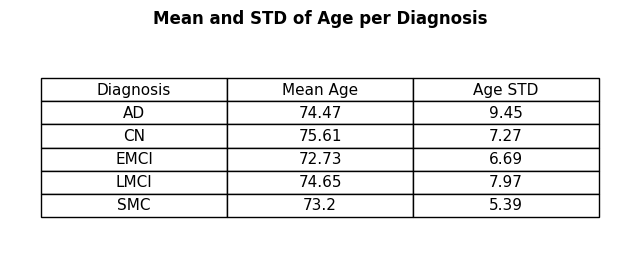

In [ ]:
#Calculate few statistics for the dataset


def plot_age_stats_per_diagnosis(df):
    """
    Computes the mean and standard deviation of the 'AGE' column per 'DX_bl' diagnosis category in the dataset,
    grouped by unique 'RID'. It then plots a table showing these statistics with a white background and increases
    row size for better readability. Age statistics are displayed with precision up to the fourth decimal point.

    Parameters:
    - df: A pandas DataFrame with columns 'RID', 'AGE', and 'DX_bl'.

    Returns:
    - A matplotlib plot (table) showing the mean and standard deviation of age per diagnosis category.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Grouping the data by 'RID' to find mean and std of AGE for each patient
    age_stats_per_patient = df.groupby('RID')['AGE'].agg(['mean', 'std']).reset_index()
    age_stats_per_patient['std'] = age_stats_per_patient['std'].fillna(0)  # Fill NaN std with 0

    # Merging stats back with diagnosis information, after removing duplicate RIDs
    df_no_duplicates = df.drop_duplicates(subset='RID')
    final_dataset = pd.merge(df_no_duplicates[['RID', 'DX_bl']], age_stats_per_patient, on='RID')

    # Grouping by 'DX_bl' for overall mean and std of AGE mean per diagnosis
    age_stats_per_diagnosis = final_dataset.groupby('DX_bl')['mean'].agg(['mean', 'std']).reset_index()

    # Adjusting precision to the 2nd decimal point
    age_stats_per_diagnosis['mean'] = age_stats_per_diagnosis['mean'].round(2)
    age_stats_per_diagnosis['std'] = age_stats_per_diagnosis['std'].round(2)

    # Plotting
    fig, ax = plt.subplots()
    ax.set_axis_off()
    table_data = age_stats_per_diagnosis.values.tolist()
    columns = ["Diagnosis", "Mean Age", "Age STD"]
    table = ax.table(cellText=table_data, colLabels=columns, loc='center', cellLoc='center', rowLoc='center')
    table.set_fontsize(11)
    table.scale(0.9, 2)  # Adjusting scale for better readability


    for pos, cell in table.get_celld().items():
        cell.set_height(.1)  # Adjusting the row height

    ax.set_title('Mean and STD of Age per Diagnosis', fontweight='bold')
    plt.gcf().set_size_inches(8, 3)
    plt.gca().patch.set_facecolor('white')
    plt.gca().axis('off')
    plt.show()

plot_age_stats_per_diagnosis(Dataset_final)



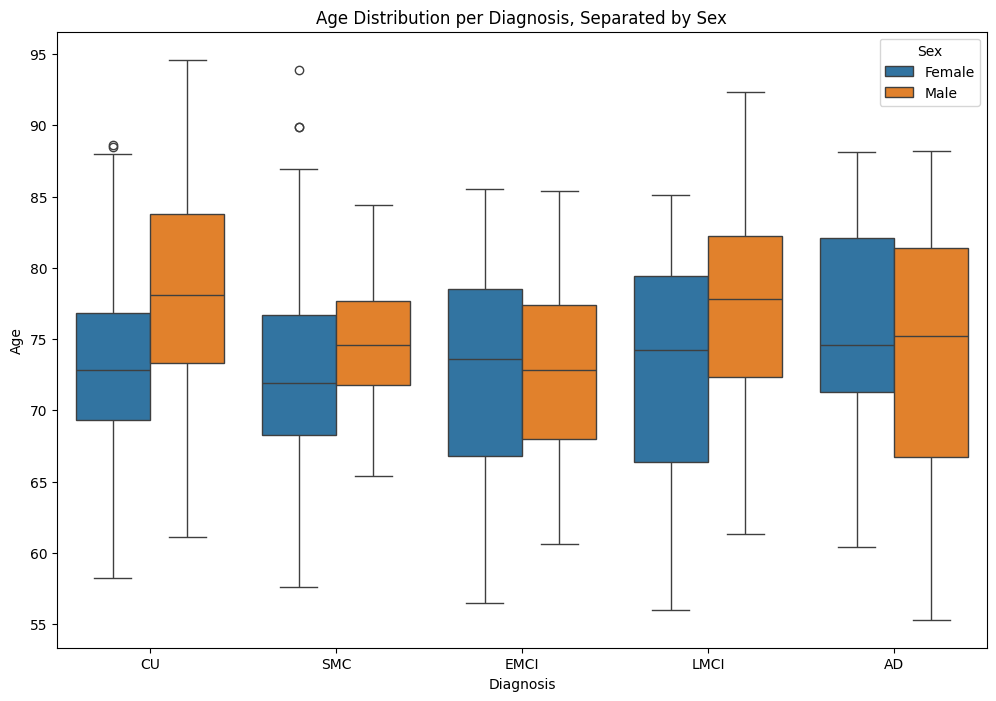

In [ ]:
# We can use a boxplot to visualize the age distribution within each diagnosis, separated by gender
df = Dataset_final
# Create a new 'Gender' column with string values for better visualization
df['Gender'] = df['PTGENDER'].map({1: 'Male', 0: 'Female'})
# Rename 'CN' in 'DX_bl' column to 'CU'
df['DX_bl'] = df['DX_bl'].replace({'CN': 'CU'})


# Ensure 'DX_bl' is of type category with the given order
order = ['CU', 'SMC', 'EMCI', 'LMCI', 'AD']
df['DX_bl'] = pd.Categorical(df['DX_bl'], categories=order, ordered=True)

# Now, when you plot, the categories will appear in the defined order
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='DX_bl', y='AGE', hue='Gender', order=order)
plt.title('Age Distribution per Diagnosis, Separated by Sex')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.legend(title='Sex')
plt.show()


# Splits fnc

In [ ]:

#age_mean = Dataset_final['AGE'].mean()
#age_std = Dataset_final['AGE'].std()
#Dataset_final.loc[:, 'AGE'] = (Dataset_final['AGE'] - age_mean) / age_std
#print mean and std
#print('AGE Mean',age_mean)
#print('AGE std',age_std)


#APPLY Z-SCORE TO NORMALIZE AGE, PRINT MEAN & STD for future records
#Dataset_final.loc[:, 'AGE'] = (Dataset_final['AGE'] - age_mean) / age_std

#move time difference to last column
cols =  [col for col in Dataset_final.columns if col != 'Time_Difference']+['Time_Difference']
Dataset_final = Dataset_final[cols]


timepoints_count = Dataset_final.groupby('RID').size().reset_index(name='num_timepoints')
modified_set = Dataset_final.merge(timepoints_count, on='RID', how='left')
modified_set.rename(columns={'num_timepoints_x': 'num_timepoints'}, inplace=True)
# This should be applied to 'modified_set', not 'Dataset_final', since 'modified_set' is the updated DataFrame
cols = ['num_timepoints'] + [col for col in modified_set.columns if col != 'num_timepoints']
modified_set = modified_set[cols]

modified_set.head()
Dataset_final=modified_set
Dataset_final.shape

(588, 92)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# List of diagnosis columns
diagnostic_cols = ['DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI', 'DX_bl_LMCI', 'DX_bl_SMC']

# Grouping dataset by 'RID' to work on each patient's data


# Splitting patient IDs into training and testing groups, ensuring each group has a proportional representation of diagnoses
# 'test_size=0.2' means 20% of the data goes into the test set
# 'random_state=11' ensures the split is reproducible
# 'stratify=RID_diagnosis['DX_bl']' ensures the split is stratified by the diagnosis


def generate_n_splits(Dataset_final, n_splits, test_size=0.2, random_state=11):


    grouped = Dataset_final.groupby('RID')
    RID_diagnosis = grouped['DX_bl'].agg(lambda x: x.mode()[0]).reset_index()
    #print(RID_diagnosis.head())
    #print(RID_diagnosis.shape)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    splits = {}

    # Generate indices for each split
    for idx, (train_index, test_index) in enumerate(skf.split(RID_diagnosis, RID_diagnosis['DX_bl'])):
        train_RIDs = RID_diagnosis.iloc[train_index]
        test_RIDs = RID_diagnosis.iloc[test_index]

        # Filter the main dataset to create train and test sets based on the indices
        train = Dataset_final[Dataset_final['RID'].isin(train_RIDs['RID'])]
        test = Dataset_final[Dataset_final['RID'].isin(test_RIDs['RID'])]

        # Store each train and test pair in the dictionary with dynamic naming
        splits[f'train{idx+1}'] = train
        splits[f'test{idx+1}'] = test

    # Optionally print out unique RID counts for each split
    for i in range(1, n_splits+1):
        print(f"Split {i}: Number of unique RID train: {splits[f'train{i}']['RID'].nunique()}, Number of unique RID test: {splits[f'test{i}']['RID'].nunique()}")
        print("This is generate_n_splits_and_store function \n")
    return splits

Outer_Loop_Splits=5

dataset_splits = generate_n_splits(Dataset_final, Outer_Loop_Splits)

# Accessing variables
train1 = dataset_splits['train1']
test1 = dataset_splits['test1']
train2 = dataset_splits['train2']
test2 = dataset_splits['test2']
train3 = dataset_splits['train3']
test3 = dataset_splits['test3']
train4 = dataset_splits['train4']
test4 = dataset_splits['test4']
train5 = dataset_splits['train5']
test5 = dataset_splits['test5']

Dataset_final.shape
print(type(Dataset_final))
print(type(train1))

print(train1.shape)
print(test1.shape)
print('\n')
Dataset_final.shape
train1.head()




In [ ]:

def plot_histograms(train_dataset, test_dataset, feature_mapping, set1, set2):
    # Custom feature names in the desired order
    custom_feature_names = ['CU', 'SMC', 'EMCI', 'LMCI', 'AD']
    bar_width = 0.2
    index = np.arange(len(custom_feature_names))

    train_counts = []
    test_counts = []

    for custom_name in custom_feature_names:
        # Use the mapping to get the actual dataset column name
        col = feature_mapping[custom_name]

        train_count = train_dataset[col].value_counts().get(1, 0)
        test_count = test_dataset[col].value_counts().get(1, 0)
        train_counts.append(train_count)
        test_counts.append(test_count)

    plt.figure(figsize=(10, 6))
    plt.bar(index, train_counts, bar_width, label=set1)
    plt.bar(index + bar_width, test_counts, bar_width, label=set2)

    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Diagnosis in Training and Testing')
    plt.xticks(index + bar_width / 2, custom_feature_names)
    plt.legend()
    plt.tight_layout()
    plt.show()


feature_mapping = {
    'CU': 'DX_bl_CN',
    'SMC': 'DX_bl_SMC',
    'EMCI': 'DX_bl_EMCI',
    'LMCI': 'DX_bl_LMCI',
    'AD': 'DX_bl_AD'
}

unique_rid_count = Dataset_final['RID'].nunique()
print(f"Number of unique RID Total : {unique_rid_count}")
num_datapoints = Dataset_final.shape[0]
print(f"Number of data points Total: {num_datapoints}")

def summarize_dataset(train, test):
    """
    Print summary statistics for training and testing datasets including the number of unique RIDs
    and the total number of data points.

    Args:
    train (DataFrame): The training dataset.
    test (DataFrame): The testing dataset.
    """
    # Training set summary
    unique_rid_count_train = train['RID'].nunique()
    num_datapoints_train = train.shape[0]
    print(f"Number of unique RID in Training: {unique_rid_count_train}")
    print(f"Number of data points in the training dataset: {num_datapoints_train}")

    # Testing set summary
    unique_rid_count_test = test['RID'].nunique()
    num_datapoints_test = test.shape[0]
    print(f"Number of unique RID in Testing: {unique_rid_count_test}")
    print(f"Number of data points in the testing dataset: {num_datapoints_test}")


summarize_dataset(train1, test1)
summarize_dataset(train2, test2)
summarize_dataset(train3, test3)
summarize_dataset(train4, test4)
summarize_dataset(train5, test5)




Number of unique RID Total : 263
Number of data points Total: 588
Number of unique RID in Training: 210
Number of data points in the training dataset: 468
Number of unique RID in Testing: 53
Number of data points in the testing dataset: 120
Number of unique RID in Training: 210
Number of data points in the training dataset: 465
Number of unique RID in Testing: 53
Number of data points in the testing dataset: 123
Number of unique RID in Training: 210
Number of data points in the training dataset: 471
Number of unique RID in Testing: 53
Number of data points in the testing dataset: 117
Number of unique RID in Training: 211
Number of data points in the training dataset: 473
Number of unique RID in Testing: 52
Number of data points in the testing dataset: 115
Number of unique RID in Training: 211
Number of data points in the training dataset: 475
Number of unique RID in Testing: 52
Number of data points in the testing dataset: 113


In [ ]:
with pd.option_context('display.max_columns', None):  # None means unlimited
    display(train1.head(1))
# tau  1.303	to  1.482

# Features Extract- Target

In [ ]:
def extract_features_and_targets(data):
    """
    Processes the dataset to extract features and targets for each RID group.
    Features include tau and amyloid values, while targets are future tau values.
    Exclude the last 6 columns which are RID, PTGEN etc demographics features, except for the diag column which is included in features.

    Parameters:
    - data: DataFrame containing the entire dataset.

    Returns:
    - X_all: A list of brain regions with all suvr values
    - y_all: A list of target arrays for all applicable data points.
    - rids_all: A list of RIDs for all applicable data points, aligned with X_all and y_all.
    - diag_array: A list of diagnostic features aligned with X_all.
    - target_names: A list of target names aligned with y.
    """
    X_all = []
    y_all = []
    rids_all = []
    diag_array = []
    bias = []
    Age_all = []
    PTGENDER_all = []
    y_col_names = []
    timediff=[]
    Apoe_all=[]
    # Loop over each RID
    for rid, group in data.groupby('RID'):
        # Exclude the last 6 columns which are assumed to be diagnostic features
        # And include the diag feature column (index 4) for diagnostic purposes
        all_tau_features = group.iloc[:, 6:-6]
        diag_feature = group.iloc[:, 3]
        datapoints=group.iloc[:, 0]
        PTGENDER = group.iloc[:, 2]
        AGE = group.iloc[:, 4]
        #Assumes that the last column is "Time_Difference"
        Delta_t=group.iloc[:, -1]
        apoe_list=group.iloc[:,5]
        #print(Delta_t)

        # Extract tau value
        # Filter out amyloid columns for X, but keep them for y prediction target
        tau_columns = [col for col in all_tau_features.columns if not col.endswith('_AMY')]
        amy_columns = [col for col in all_tau_features.columns if col.endswith('_AMY')]

        # Extract tau and amyloid values
        tau_values = group[tau_columns].values
        amy_values = group[amy_columns].values

        if not y_col_names:
          y_col_names = tau_columns
        # Iterate over the group to align current features with future tau values
        for i in range(len(tau_values) - 1):  # Ensure there's a next time point to predict
            # Current features include both current tau and amyloid values
            X = np.concatenate((tau_values[i], amy_values[i]), axis=None)

            # Future tau values as target
            y = tau_values[i + 1]  # next row represents the future time point

            # Append the current features and future tau values to their respective lists
            X_all.append(X)
            y_all.append(y)
            timediff.append(Delta_t.iloc[i+1])
            diag_array.append(diag_feature.iloc[i])  # Append the diagnostic feature
            bias.append(datapoints.iloc[i])  # Append the datapoint
            Age_all.append(AGE.iloc[i])
            Apoe_all.append(apoe_list.iloc[i])
            PTGENDER_all.append(PTGENDER.iloc[i])
            rids_all.append(rid)
    adjusted_bias =  [x - 1 for x in bias] # 2 scans mean 1 observation thus -1
    return np.array(X_all), np.array(y_all), np.array(rids_all), np.array(diag_array), np.array(adjusted_bias), y_col_names, np.array(timediff), np.array(Age_all), np.array(PTGENDER_all), np.array(Apoe_all)




In [ ]:
#train_set=remove_Amy(train1)
#test=remove_Amy(test1)


# bias test and train refers to the number of data points each RID has, min is 2 max is 4

#np.array(X_all), np.array(y_all), np.array(rids_all), np.array(diag_array), np.array(datapoints_array), y_col_names, np.array(timediff), np.array(Age_all), np.array(PTGENDER_all), np.array(Apoe_all)
#Prepare labels
X_train, y_train,train_rid,diag_array, bias_train, roi , Time_diff_train, age_train, gndr_train, apoe_train=extract_features_and_targets(Dataset_final)

In [ ]:
age_train_df=pd.DataFrame(apoe_train)
age_train_df.head()


In [ ]:
gndr_train_df=pd.DataFrame(gndr_train)
gndr_train_df.head()

# GGSEG features mapping + Correlation

In [ ]:
from math import nan
from itertools import islice
#roi was extracted prevously as a list roi
# Removing "CTX_", "_SUVR" from each string and converting to lowercase
print(roi)
processed_list_step1 = [item.replace('CTX_', '').replace('_SUVR', '').lower() for item in roi]
processed_list_step2 = [
    item.replace('rh_', '') + '_right' if 'rh_' in item else item
    for item in processed_list_step1]
processed_list_step3 = [
    item.replace('lh_', '') + '_left' if 'lh_' in item else item
    for item in processed_list_step2]



def replace_accumbens_area(data):
    replaced_data = []
    for item in data:
        if item == 'left_accumbens_area':
            replaced_data.append('NA_left')
        elif item == 'right_accumbens_area':
            replaced_data.append('NA_right')
        else:
            replaced_data.append(item)
    return replaced_data



processed_list_step4 = replace_accumbens_area(processed_list_step3)
print(processed_list_step4)
print (len(processed_list_step4))

# The following code is how we found missing regions list
#unique_to_processed_list= [item for item in processed_list_step4 if item not in roi_list and item not in brain_regions ]
#print("missing regions", unique_to_processed_list)
#print(len(unique_to_processed_list))





print("Put the remanining regions in our dataset in a list \n")
# Put the remanining regions in our dataset in a list

missing_regions = ['left_amygdala', 'left_caudate', 'left_hippocampus', 'left_pallidum', 'left_putamen', 'left_thalamus_proper', 'right_amygdala', 'right_caudate', 'right_hippocampus', 'right_pallidum', 'right_putamen', 'right_thalamus_proper']


def transform_string(s):
    return '-'.join(part.capitalize() for part in s.split('_'))

# Transform strings in unique_to_processed_list based on their presence and format in missing_regions
transformed_unique_to_processed_list = []
for s in processed_list_step4:
    if 'proper' in s.lower():
            s = s.replace('_proper', '')
            transformed_s = transform_string(s)
            transformed_unique_to_processed_list.append(transformed_s)
    elif s.lower() in [s.lower() for s in missing_regions]:
        # Apply transformation if the lowercase version matches
        transformed_s = transform_string(s)
        transformed_unique_to_processed_list.append(transformed_s)
    else:
      transformed_unique_to_processed_list.append(s)



Features= transformed_unique_to_processed_list
print(Features)
print(len(Features))

#Final_Features

In [ ]:
Dataset_final.head()

In [ ]:
type(Dataset_final['Time_Difference'][1] )

pandas._libs.tslibs.timedeltas.Timedelta

In [ ]:
def plot_correlation_matrix_with_labels_and_numbers(X, feature_names):
    # Ensure feature_names has the same length as the number of features in X
    assert X.shape[1] == len(feature_names), "The length of feature_names must match the number of features in X"

    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    vmax = np.abs(corr_matrix).max()
    # Plotting the correlation matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=0, vmax=vmax)
    plt.title('Correlation Matrix', pad=20)

    # Adding a color bar to make interpretation easier
    fig.colorbar(cax)

    # Setting the ticks and labels with the feature names
    ticks = np.arange(len(feature_names))
    plt.xticks(ticks, feature_names, rotation=90)
    plt.yticks(ticks, feature_names)

    # Annotating each cell with the correlation coefficient
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                           ha="center", va="center", color="w")

    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature')

    plt.show()


# use only cross sectional data for correlation

unique_RID_df = Dataset_final.drop_duplicates(subset='RID')

# Columns to drop
columns_to_drop = [
    'RID', 'PTGENDER', 'DX_bl', 'AGE', 'APOE4', 'DX_bl_AD', 'DX_bl_CN',
    'DX_bl_EMCI', 'DX_bl_LMCI', 'DX_bl_SMC', 'Gender', 'Time_Difference'
]

# Dropping the specified columns from Dataset_final and saving the result in d
D = unique_RID_df.drop(columns=columns_to_drop)





Keep_columns = [col for col in D.columns if not col.endswith('_AMY')]
D_filtered = D[Keep_columns]

#print(D_filtered.shape)
#print(D_filtered.head())


words = ['amygdala', 'accumbens', 'caudate', 'hippocampus', 'pallidum', 'putamen', 'thalamus']
D_columns = D_filtered.columns
Keep_columns = [col for col in D_columns if any(word in col.lower() for word in words) and col in D_columns]
Subcortical_df=D_filtered[Keep_columns]
Subcortical_feature_list= [feature for feature in Features if any(word in feature.lower() for word in words)]

print(Subcortical_feature_list)
print(Subcortical_df.shape)
print(len(Subcortical_feature_list))

#plot_correlation_matrix_with_labels_and_numbers(Subcortical_df,Subcortical_feature_list)


def plot_correlation_matrix_with_labels_no_numbers(X, feature_names):
    # Ensure feature_names has the same length as the number of features in X
    assert X.shape[1] == len(feature_names), "The length of feature_names must match the number of features in X"

    # Calculate the correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    vmax = np.abs(corr_matrix).max()

    # Plotting the correlation matrix
    fig, ax = plt.subplots(figsize=(19, 19))
    cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=0, vmax=vmax)

    plt.title('Correlation Matrix', pad=20)

    # Adding a color bar to make interpretation easier
    fig.colorbar(cax)

    # Setting the ticks and labels with the feature names
    ticks = np.arange(len(feature_names))
    plt.xticks(ticks, feature_names, rotation=90)
    plt.yticks(ticks, feature_names)

    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature')

    plt.show()




#plot_correlation_matrix_with_labels_no_numbers(D_filtered, Features)




# Grid Seach

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def GridSearch(train_data, activations, learning_rates, epochs_list, hidden_layers_list, neurons_per_layer_list, n_splits):
    best_overall_mae = float('inf')
    best_hyperparameters_per_fold = []
    #print(train_data.shape)
    #train_set=remove_Amy(train_data)
    dataset_splits = generate_n_splits(train_data, n_splits)

    # Iterate over each fold
    for i in range(1,n_splits+1):
        best_mae_for_fold = float('inf')
        best_hyperparameters_for_fold = {}
        key1 = f'test{i}'
        Validation_set= dataset_splits[key1]
        key2 = f'train{i}'
        Training_set= dataset_splits[key2]
        summarize_dataset(Training_set,Validation_set)
        # Standardize the age column using Z-score
        merged_set = pd.concat([Validation_set, Training_set], ignore_index=True)
        age_mean = merged_set['AGE'].mean()
        age_std = merged_set['AGE'].std()
        Validation_set.loc[:, 'AGE'] = (Validation_set['AGE'] - age_mean) / age_std
        Training_set.loc[:, 'AGE'] = (Training_set['AGE'] - age_mean) / age_std

        # 160 feature
        X_train, y_train,train_rid,diag_array_train, bias_train, roi , Time_diff_train, age_train, gndr_train, apoe_train=extract_features_and_targets(Training_set)
        X_validation, y_validation,test_rid,diag_array_test, bias_validation, roi , Time_diff_test, age_test, gndr_test, apoe_test=extract_features_and_targets(Validation_set)
        # print("First value of train_rid:", train_rid[0])
        # print("First value of diag_array_train:", diag_array_train[0])
        # print("First value of bias_train:", bias_train[0])
        # print("First value of roi:", roi[0])
        # print("First value of Time_diff_train:", Time_diff_train[0])
        # print("First value of age_train:", age_train[0])
        # print("First value of gndr_train:", gndr_train[0])
        # print("First value of apoe_train:", apoe_train[0])
        X_train = preprocess_data(X_train, diag_array_train, age_train, gndr_train, apoe_train, Time_diff_train)
        X_validation = preprocess_data(X_validation, diag_array_test, age_test, gndr_test, apoe_test, Time_diff_test)


        # Iterate over each combination of hyperparameters for the current fold
        for activation in activations:
            for learning_rate in learning_rates:
                for epochs in epochs_list:
                    for hidden_layers in hidden_layers_list:
                        for neurons_per_layer in neurons_per_layer_list:
                            print(f"Fold: {i}, Hyperparameters: Activation: {activation}, LR: {learning_rate}, Epochs: {epochs}, Hidden Layers: {hidden_layers}, Neurons/Layer: {neurons_per_layer}")

                            # Train and evaluate the model on the current fold and hyperparameter combination
                            model = train_mlp_model(X_train, y_train, X_validation, y_validation, activation, bias_train, bias_validation, learning_rate, epochs, hidden_layers, neurons_per_layer)
                            mae_dic_new, mae_avg = evaluate_model_per_feature(model, X_validation, y_validation)
                            print(mae_avg)
                            if mae_avg < best_mae_for_fold:
                              best_mae_for_fold = mae_avg
                              best_hyperparameters_for_fold = {'fold' : i,'activation': activation, 'learning_rate': learning_rate, 'epochs': epochs, 'hidden_layers': hidden_layers, 'neurons_per_layer': neurons_per_layer}

        # After evaluating all hyperparameters for the current fold, store the best for that fold
        best_hyperparameters_per_fold.append(best_hyperparameters_for_fold)
    return  best_hyperparameters_per_fold




global_dict_of_dicts_train = {}
global_dict_of_dicts_test={}

def save_dict_to_global_store_train(key, input_dict):
    """
    Saves the given dictionary into a global dictionary of dictionaries.
    """
    # Ensure the global dictionary is accessible
    global global_dict_of_dicts_train

    # Save the input dictionary under the provided key
    global_dict_of_dicts_train[key] = input_dict

def save_dict_to_global_store_test(key, input_dict):
    """
    Saves the given dictionary into a global dictionary of dictionaries.
    """
    # Ensure the global dictionary is accessible
    global global_dict_of_dicts_test

    # Save the input dictionary under the provided key
    global_dict_of_dicts_test[key] = input_dict

def create_mlp_model(input_dim, output_dim, hidden_layers, neurons_per_layer, activation):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(tf.keras.layers.Dense(neurons_per_layer, activation=activation))
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))
    return model

def train_mlp_model(X_train, y_train, X_validation, y_validation, activation, bias_train, bias_validation, learning_rate, epochs, hidden_layers, neurons_per_layer):
    model = create_mlp_model(X_train.shape[1], y_train.shape[1], hidden_layers, neurons_per_layer, activation)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
   # n_outputs = y_train.shape[1]
   # output_names = [f'output{i}' for i in range(1, n_outputs)]
   #metrics={name: ['mae'] for name in output_names}
    sample_weights_train = 1 / bias_train
    sample_weights_validation = 1 / bias_validation
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'], weighted_metrics=['mae'])
    history = model.fit(X_train, y_train, sample_weight=sample_weights_train, epochs=epochs, validation_data=(X_validation, y_validation, sample_weights_validation), verbose=0)
    return model



def evaluate_model_per_feature(model, X_test, y_test):
    predictions = model.predict(X_test)
    # Initialize a dictionary to store MAE for each output with the index as the key
    mae_dict = {}
    # Calculate MAE for each output and store it in the dictionary
    for i in range(y_test.shape[1]):  # y_test is a 2D array with shape (n_samples, n_outputs)
        mae = mean_absolute_error(y_test[:, i], predictions[:, i])
        mae_dict[i] = mae  # Use output index as the key
    mean_mae = np.mean(list(mae_dict.values()))
    return mae_dict, mean_mae



def plot_box_plots_from_global_dicts(global_dict_of_dicts_train, global_dict_of_dicts_test):
    """
    Generates box plots for each key in each dictionary stored within the provided global dictionaries of dictionaries.
    Each key's list of values will be used to generate a separate box plot for both training and testing datasets.
    """
    # Combine the two dictionaries for iteration, labeling them accordingly
    combined_dict = {'Train': global_dict_of_dicts_train, 'Test': global_dict_of_dicts_test}

    # Iterate through the combined dictionary
    for dataset_type, global_dict in combined_dict.items():
        # Iterate through each dictionary in the global dictionary
        for dict_name, sub_dict in global_dict.items():
            # Iterate through each key in the dictionary
            for key, values in sub_dict.items():
                # Generate a box plot for the list of values
                plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
                plt.boxplot(values)
                plt.title(f'Box plot for {Features[key]} in {dict_name} ({dataset_type})')
                plt.ylabel('Values')
                plt.xticks([1], Features[key])  # Setting the x-axis to show the key name
                plt.show()



    for ax, (key, inner_dict) in zip(axs, dict_of_dicts.items()):
        # Extracting all lists from the inner dictionary for plotting
        data = [value for value in inner_dict.values()]
        # Creating box plot for each list
        ax.boxplot(data)
        ax.set_title(f'Box plot for {key}')
        ax.set_xticklabels(inner_dict.keys(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def preprocess_data(X_data, diag_array_data, age_data, gndr_data, apoe_data, Time_diff_data):
    #print(type(X_data))
    # Add age, gender, and apoe as features

    #X_data = np.hstack((gndr_data[:, np.newaxis], X_data))
    #X_data = np.hstack((apoe_data[:, np.newaxis], X_data))
    #X_data = np.hstack((age_data[:, np.newaxis], X_data))

    # Add time_diff as input
    timedeltas_in_days = Time_diff_data.astype('timedelta64[D]').astype(int)
    X_data = np.hstack((timedeltas_in_days[:, np.newaxis], X_data))

    # One-hot encode diagnosis features
    # encoder = OneHotEncoder()
    # diag_array_reshaped = diag_array_data.reshape(-1, 1)
    # DX_bl_encoded = encoder.fit_transform(diag_array_reshaped).toarray()
    # encoded_data = pd.DataFrame(DX_bl_encoded, columns=encoder.get_feature_names_out(['DX_bl']))
    # diag_array_final = pd.concat([pd.DataFrame(diag_array_reshaped), encoded_data], axis=1)
    # diag_array_final_np = diag_array_final.to_numpy()
    # diagnosis_arr=diag_array_final_np[:, 1:]
    # diagnosis_arr = diagnosis_arr.astype(float)
    # X_data = np.hstack((X_data, diagnosis_arr))

    return X_data



#,'selu', 'swish','relu',
activations = ['leaky_relu','elu']
learning_rates = [0.001]
#0.01
#400
epochs_list = [200,600]
hidden_layers_list = [3,4]
#2
neurons_per_layer_list = [16,32, 64, 128]
    #16,32, 64, 128]

Inner_Loop_Splits=5

Final_hyperparameters_all=[]

for i in range(5,6):
    key_B = f'train{i}'
    Train_Split= dataset_splits[key_B]
    print("Outer_Loop")
    print(Train_Split.shape)
    print("Outer_Loop \n")

    best_hyperparameters = GridSearch(Train_Split, activations, learning_rates, epochs_list, hidden_layers_list, neurons_per_layer_list,Inner_Loop_Splits)
    Final_hyperparameters_all.append(best_hyperparameters)

#np.array(X_all), np.array(y_all), np.array(rids_all), np.array(diag_array), np.array(datapoints_array), y_col_names, np.array(timediff), np.array(Age_all), np.array(PTGENDER_all), np.array(Apoe_all)

Outer_Loop
(475, 92)
Outer_Loop 

Split 1: Number of unique RID train: 168, Number of unique RID test: 43
This is generate_n_splits_and_store function 

Split 2: Number of unique RID train: 169, Number of unique RID test: 42
This is generate_n_splits_and_store function 

Split 3: Number of unique RID train: 169, Number of unique RID test: 42
This is generate_n_splits_and_store function 

Split 4: Number of unique RID train: 169, Number of unique RID test: 42
This is generate_n_splits_and_store function 

Split 5: Number of unique RID train: 169, Number of unique RID test: 42
This is generate_n_splits_and_store function 

Number of unique RID in Training: 168
Number of data points in the training dataset: 376
Number of unique RID in Testing: 43
Number of data points in the testing dataset: 99
Fold: 1, Hyperparameters: Activation: leaky_relu, LR: 0.001, Epochs: 200, Hidden Layers: 3, Neurons/Layer: 16
2/2 [==============================] - 0s 4ms/step
0.14799729827163474
Fold: 1, Hyperpa

In [ ]:
for i in range(1, len(Final_hyperparameters_all)):
  for j in Final_hyperparameters_all[i]:
    print(j)
#for i in range(1,Outer_Loop_Splits+1):

In [ ]:
path = '/content/gdrive/MyDrive/Neuro_Tau'
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, 'Best_models.pkl')
with open(file_path, 'wb') as file:
    pickle.dump(Final_hyperparameters_all, file)

print(f'Best_models has been pickled and saved to {file_path}')



Best_models has been pickled and saved to /content/gdrive/MyDrive/Neuro_Tau/Best_models.pkl


In [ ]:
path = '/content/gdrive/MyDrive/Neuro_Tau'
os.makedirs(path, exist_ok=True)
# Load the pickle file
with open(file_path, 'rb') as file:
    Final_hyperparameters_all = pickle.load(file)

# Print the loaded parameters to verify
print('Loaded model parameters:', Final_hyperparameters_all)

Loaded model parameters: [[{'fold': 1, 'activation': 'leaky_relu', 'learning_rate': 0.001, 'epochs': 600, 'hidden_layers': 4, 'neurons_per_layer': 32}, {'fold': 2, 'activation': 'elu', 'learning_rate': 0.001, 'epochs': 600, 'hidden_layers': 4, 'neurons_per_layer': 128}, {'fold': 3, 'activation': 'leaky_relu', 'learning_rate': 0.001, 'epochs': 600, 'hidden_layers': 4, 'neurons_per_layer': 64}, {'fold': 4, 'activation': 'leaky_relu', 'learning_rate': 0.001, 'epochs': 600, 'hidden_layers': 4, 'neurons_per_layer': 64}, {'fold': 5, 'activation': 'elu', 'learning_rate': 0.001, 'epochs': 600, 'hidden_layers': 4, 'neurons_per_layer': 64}]]


In [ ]:
for i in range(1, len(Final_hyperparameters_all)):
  for j in Final_hyperparameters_all[i]:
    print(j)

# Baseline model

In [ ]:
# baseline dummy model

def dummy_model_per_feature(X_test, y_test):
    # Initialize a dictionary to store MAE for each output with the index as the key
    mae_dict = {}
    # Calculate MAE for each output and store it in the dictionary
    for i in range(y_test.shape[1]):  # y_test is a 2D array with shape (n_samples, n_outputs)
        mean_mae  = mean_absolute_error(y_test[:, i], X_test[:, i])
        mae_dict[i+1] = mean_mae  # Use output index as the key
    return mae_dict, mean_mae


dummy_mae_dict, dummy_mean_mae= dummy_model_per_feature(X_test, y_test)
print(dummy_mae_dict)
print(dummy_mean_mae)
print(Features)

In [ ]:
def dummy_model_per_feature_per_sample(X_test, y_test):
    # Initialize a dictionary to store MAE for each output with the index as the key
    mae_dict = {}
    # Calculate MAE for each output and store it in the dictionary
    for i in range(y_test.shape[1]):  # y_test is a 2D array with shape (n_samples, n_outputs)
        error  = np.abs(y_test[:, i], X_test[:, i])
        mae_dict[i+1] = error  # Use output index as the key
    return mae_dict
box_plot_dummy_dict = dummy_model_per_feature_per_sample(X_test, y_test)


# GGSEG preprocess+ plot

In [ ]:
pip install ggseg

In [ ]:
##### OUR DATASET MUST MATCH THE FOLLOWING NAMING FORMAT #######
# more info on ggseg https://ggseg.github.io/ggseg/index.html
# list of fully applicable regions mentioned in https://github.com/ggseg/python-ggseg/tree/main/ggseg/data/dk , and summarized below
roi_list = [
    "NA_left",
    "NA_right",
    "bankssts_left",
    "bankssts_right",
    "caudalanteriorcingulate_left",
    "caudalanteriorcingulate_right",
    "caudalmiddlefrontal_left",
    "caudalmiddlefrontal_right",
    "corpuscallosum_left",
    "corpuscallosum_right",
    "cuneus_left",
    "cuneus_right",
    "entorhinal_left",
    "entorhinal_right",
    "fusiform_left",
    "fusiform_right",
    "inferiorparietal_left",
    "inferiorparietal_right",
    "inferiortemporal_left",
    "inferiortemporal_right",
    "insula_left",
    "insula_right",
    "isthmuscingulate_left",
    "isthmuscingulate_right",
    "lateral_left",
    "lateral_right",
    "lateraloccipital_left",
    "lateraloccipital_right",
    "lateralorbitofrontal_left",
    "lateralorbitofrontal_right",
    "lingual_left",
    "lingual_right",
    "medial_left",
    "medial_right",
    "medialorbitofrontal_left",
    "medialorbitofrontal_right",
    "middletemporal_left",
    "middletemporal_right",
    "paracentral_left",
    "paracentral_right",
    "parahippocampal_left",
    "parahippocampal_right",
    "parsopercularis_left",
    "parsopercularis_right",
    "parsorbitalis_left",
    "parsorbitalis_right",
    "parstriangularis_left",
    "parstriangularis_right",
    "pericalcarine_left",
    "pericalcarine_right",
    "postcentral_left",
    "postcentral_right",
    "posteriorcingulate_left",
    "posteriorcingulate_right",
    "precentral_left",
    "precentral_right",
    "precuneus_left",
    "precuneus_right",
    "rostralanteriorcingulate_left",
    "rostralanteriorcingulate_right",
    "rostralmiddlefrontal_left",
    "rostralmiddlefrontal_right",
    "superiorfrontal_left",
    "superiorfrontal_right",
    "superiorparietal_left",
    "superiorparietal_right",
    "superiortemporal_left",
    "superiortemporal_right",
    "supramarginal_left",
    "supramarginal_right",
    "transversetemporal_left",
    "transversetemporal_right"

]
print(len(roi_list))

# below is a list of subcortical regions supported
#full list of subcortical regions is available through this link https://github.com/ggseg/python-ggseg/tree/main/ggseg/data/aseg  and summarized below

brain_regions = [
    "3rd-Ventricle",
    "4th-Ventricle",
    "Brain-Stem",
    "CC_Anterior",
    "CC_Central",
    "CC_Mid_Anterior",
    "CC_Mid_Posterior",
    "CC_Posterior",
    "Cerebellum-Cortex",
    "Cerebellum-White-Matter",
    "Coronal",
    "Left-Amygdala",
    "Left-Caudate",
    "Left-Hippocampus",
    "Left-Lateral-Ventricle",
    "Left-Pallidum",
    "Left-Putamen",
    "Left-Thalamus",
    "Left-VentralDC",
    "Right-Amygdala",
    "Right-Caudate",
    "Right-Hippocampus",
    "Right-Lateral-Ventricle",
    "Right-Pallidum",
    "Right-Putamen",
    "Right-Thalamus",
    "Right-VentralDC",
    "Sagittal"
]

print(len(brain_regions))




In [ ]:
#Proof that our list format matches ggseg format, it should return empty list for uniq , len of transformed_unique_to_processed_list should be 82 which are the num of brain regions we have
unique_to_processed_list= [item for item in transformed_unique_to_processed_list if item not in roi_list and item not in brain_regions ]

print("unique_to_processed_list:", unique_to_processed_list)
print(len(transformed_unique_to_processed_list))
print(transformed_unique_to_processed_list)

In [ ]:
best_model = 'Hyperparameters: Activation: leaky_relu, LR: 0.001, Epochs: 500, Hidden Layers: 4, Neurons/Layer: 128'

best_model='Hyperparameters: Activation: relu, LR: 0.001, Epochs: 800, Hidden Layers: 3, Neurons/Layer: 128'

best_model='Hyperparameters: Activation: swish, LR: 0.001, Epochs: 800, Hidden Layers: 4, Neurons/Layer: 128'

print(Features)
print(len(Features))
dictionary_of_best_model_train = {key: value for key, value in global_dict_of_dicts_train.items() if key == best_model}
inner_dict = next(iter(dictionary_of_best_model_train.values()))
final_dict_train = {i+1: np.mean(values) for i, values in inner_dict.items()}

dictionary_of_best_model_test = {key: value for key, value in global_dict_of_dicts_test.items() if key == best_model}
inner_dict = next(iter(dictionary_of_best_model_test.values()))
final_dict_test = {i+1: np.mean(values) for i, values in inner_dict.items()}

def remap_keys(final_dict_test, Features):
    """
    Remaps keys from final_dict_test using the Features list to new keys
    """
    ggseg_dic = {}
    for key in final_dict_test.keys():
        #print(key)
        new_key = Features[int(key) - 1]  # Map old key to new key using Features list
        new_value = final_dict_test[key]  # Get the corresponding value
        ggseg_dic[new_key] = new_value  # Update ggseg_format_dic_train with the new key-value pair

    # Optionally, return the updated dictionary
    return ggseg_dic


ggseg_format_dic_test = remap_keys(final_dict_test, Features)
#ggseg_format_dic_train = remap_keys(final_dict_train, Features)
ggseg_format_dic_dummy= remap_keys(dummy_mae_dict, Features)

print (ggseg_format_dic_test)
#print (ggseg_format_dic_train)
print (ggseg_format_dic_dummy)
#print(dummy_mae_dict)

In [ ]:
import unittest
import ggseg

#unify the scale

# Combine the values from both dictionaries
combined_values = list(ggseg_format_dic_test.values()) + list(ggseg_format_dic_dummy.values())

# Find the minimum and maximum values
min_value = min(combined_values)
max_value = max(combined_values)

print(min_value)
print(max_value)

#min_value = 0
#max_value = 0.16

ggseg.plot_dk(ggseg_format_dic_test, background='w', edgecolor='k', cmap='hot', title="Testing"+ best_model, ylabel='Error', vminmax=[min_value,max_value])
ggseg.plot_aseg(ggseg_format_dic_test, background='k', edgecolor='w', title="Testing" + best_model, bordercolor='gray', cmap='hot', ylabel='error',vminmax=[min_value,max_value])

In [ ]:
ggseg.plot_dk(ggseg_format_dic_dummy, background='w', edgecolor='k', cmap='hot', title="Baseline model", ylabel='Error', vminmax=[min_value,max_value])
ggseg.plot_aseg(ggseg_format_dic_dummy, background='k', edgecolor='w', title="Baseline model", bordercolor='gray', cmap='hot', ylabel='error', vminmax=[min_value,max_value])

In [ ]:
def remap_keys2(final_dict_test, Features):
    """
    Remaps keys from final_dict_test using the Features list to new keys.
    Expects final_dict_test to be a list of values corresponding to Features in order.
    """
    ggseg_dic = {}
    for i in range(len(Features)):
        new_key = Features[i]  # Use Feature list to map old index to new key
        new_value = final_dict_test[i]  # Get the value using string key; default to None if missing
        ggseg_dic[new_key] = new_value
    return ggseg_dic

def process_rid_data(data, rid, Features):
    # Extract rows for the given RID
    group = data[data['RID'] == rid]

    # Select the relevant columns (excluding the last 7 and first 5 columns)
    all_tau_features = group.iloc[:, 5:-7]
    remapped_dicts = []
    # Convert each row to a list of values, then map those values to Features
    rows_as_values = all_tau_features.values.tolist()
    for row in rows_as_values:
      print(row)
      remapped_row = remap_keys2(row, Features)
      remapped_dicts.append(remapped_row)
    return remapped_dicts

specific_rid_data = process_rid_data(train_set, 56, Features)

In [ ]:
print (specific_rid_data)
type(specific_rid_data)

In [ ]:
min_value = None
max_value = None

for row_dict in specific_rid_data:
    for _, value in row_dict.items():
        # Update min_value and max_value based on the current value
        if min_value is None or value < min_value:
            min_value = value
        if max_value is None or value > max_value:
            max_value = value

print(f"Minimum value across all items: {min_value}")
print(f"Maximum value across all items: {max_value}")

In [ ]:
# Assuming specific_rid_data is your list of dictionaries
for row_dict in specific_rid_data:
    # row_dict is now each dictionary within the list
    ggseg.plot_dk(row_dict, background='w', edgecolor='k', cmap='hot', title="Baseline model", ylabel='Error', vminmax=[min_value,max_value])
    ggseg.plot_aseg(row_dict, background='k', edgecolor='w', title="Baseline model", bordercolor='gray', cmap='hot', ylabel='error', vminmax=[min_value,max_value])
